In [ ]:
!pip install segmentation-models
#!pip install tensorflow==2.5.0
#!pip install keras==2.3.1
#!pip install "h5py<3.0.0"
#!pip install "scipy>=1.5"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 4.7 MB/s 


In [1]:
import tensorflow as tf
import segmentation_models as sm
import cv2
import os
import numpy as np
import glob
from matplotlib import pyplot as plt

Segmentation Models: using `keras` framework.


In [2]:
len(tf.config.list_physical_devices('GPU'))

1

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
BACKBONE = "resnet34"
preprocess_input = sm.get_preprocessing(BACKBONE)

In [5]:
SIZE_X = 256
SIZE_Y = 256

train_images = []
train_masks = []

train_num = 0
directory_path = "F:/Images/augmented"
image_folder = "aug_images"
mask_folder = "aug_masks"
image_filename_prefix = "augmented_image_"
mask_filename_prefix = "augmented_mask_"

# Get number of images
for item in glob.glob(os.path.join(directory_path, image_folder, "*.png")):
  train_num += 1

In [6]:
# Read each image using cv2.imread() and append it to the list
# Capture image and mask info as a list
for i in range(1, train_num+1):
  img_path = os.path.join(directory_path , image_folder, image_filename_prefix + str(i) + ".png")
  #print(img_path)
  img = cv2.imread(img_path, cv2.IMREAD_COLOR)
  img = cv2.resize(img, (SIZE_Y, SIZE_X))
  train_images.append(img)

  mask_path = os.path.join(directory_path , mask_folder, mask_filename_prefix + str(i) + ".png")
  mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
  mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
  train_masks.append(mask)

# Convert the lists to array for machine learning processing using np.array()
train_images = np.array(train_images)
train_masks = np.array(train_masks)

In [7]:
train_images.shape

(1000, 256, 256, 3)

In [8]:
train_masks.shape

(1000, 256, 256)

In [9]:
X = train_images
Y = train_masks
Y = np.expand_dims(Y, axis=3)

# Train test split
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.05, random_state=42)

# Preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)
y_train = y_train/255
y_val = y_val/255

In [10]:
X.shape

(1000, 256, 256, 3)

In [11]:
Y.shape

(1000, 256, 256, 1)

 Intersection over Union, a value used in object detection to measure the overlap of a predicted versus actual bounding box for an object. Value from 0 to 1, higher the score the better. IoU > 0.95 as an excellent score, IoU > 0.7 as a good one, and any other score as the poor one.

In [13]:
# Define model
model = sm.Unet(BACKBONE, encoder_weights="imagenet")
model.compile("Adam", loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])

print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 bn_data (BatchNormalization)   (None, None, None,   9           ['data[0][0]']                   
                                3)                                                                
                                                                                                  
 zero_padding2d_34 (ZeroPadding  (None, None, None,   0          ['bn_data[0][0]']                
 2D)                            3)                                                          

In [14]:
# Fit model
history = model.fit(
                x=x_train,
                y=y_train,
                batch_size=8,
                epochs=100,
                verbose=1,
                validation_data=(x_val, y_val)
            )

Epoch 1/100
119/119 [==============================] - 98s 559ms/step - loss: 1.1031 - iou_score: 0.0773 - val_loss: 2.3910 - val_iou_score: 0.0035
Epoch 2/100
119/119 [==============================] - 60s 504ms/step - loss: 0.7066 - iou_score: 0.3411 - val_loss: 690.4420 - val_iou_score: 0.0122
Epoch 3/100
119/119 [==============================] - 66s 556ms/step - loss: 0.6266 - iou_score: 0.4197 - val_loss: 0.8106 - val_iou_score: 0.2814
Epoch 4/100
119/119 [==============================] - 65s 545ms/step - loss: 0.6013 - iou_score: 0.4447 - val_loss: 0.8297 - val_iou_score: 0.2353
Epoch 5/100
119/119 [==============================] - 65s 544ms/step - loss: 0.5930 - iou_score: 0.4529 - val_loss: 0.5882 - val_iou_score: 0.4500
Epoch 6/100
119/119 [==============================] - 66s 553ms/step - loss: 0.5661 - iou_score: 0.4776 - val_loss: 0.6467 - val_iou_score: 0.4313
Epoch 7/100
119/119 [==============================] - 62s 524ms/step - loss: 0.5594 - iou_score: 0.4838 - val

function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect,60000)

Plot loss and IoU graph over number of epochs

In [15]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'iou_score', 'val_loss', 'val_iou_score'])


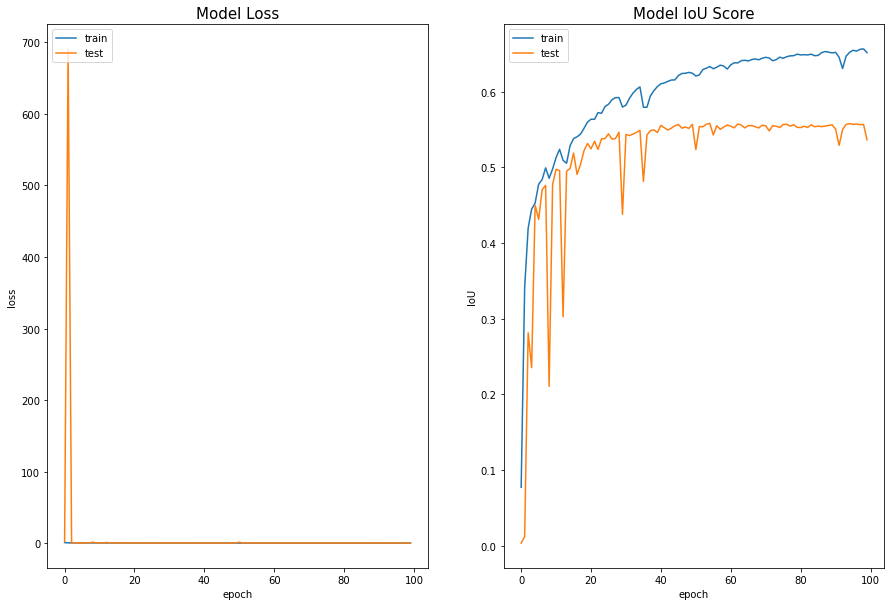

In [16]:
fig, ax = plt.subplots(1, 2 ,figsize=(15,10))
ax[0].plot(history.history["loss"])
ax[0].plot(history.history["val_loss"])
ax[0].set_title("Model Loss", fontsize="15")
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("loss")
ax[0].legend(["train", "test"], loc="upper left")

ax[1].plot(history.history["iou_score"])
ax[1].plot(history.history["val_iou_score"])
ax[1].set_title("Model IoU Score", fontsize="15")
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("IoU")
ax[1].legend(["train", "test"], loc="upper left")

Using trained model to do prediction

1/1 [==============================] - 0s 38ms/step


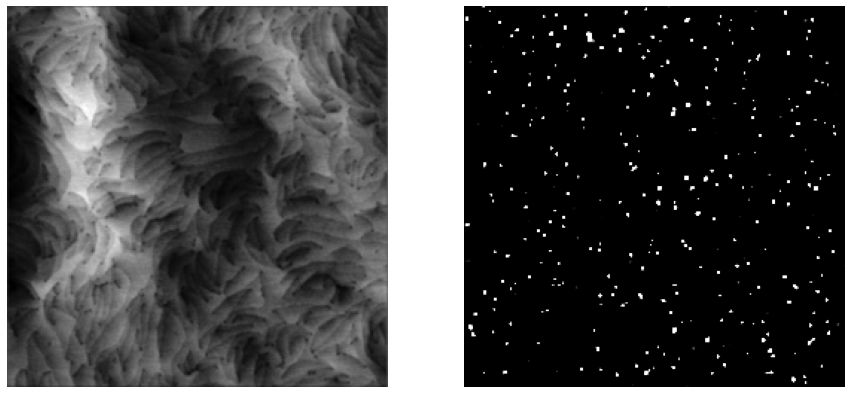

In [24]:
test_img = cv2.imread("F:/Images/512x512_images/afm_black/afm_black_4.png", cv2.IMREAD_COLOR)
test_img = cv2.resize(test_img, (SIZE_X, SIZE_Y))

fig, ax = plt.subplots(1, 2 ,figsize=(15,10))
ax[0].axis("off")
ax[0].imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY), cmap="gray") # cmap="gray" only works on a grayscaled image

test_img = np.expand_dims(test_img, axis=0)
pred_img = model.predict(test_img)
#pred_img = pred_img.reshape((256,256))

ax[1].axis("off")
ax[1].imshow(pred_img[0,:,:,0], cmap="gray")
# Error when the shape is (1,256,256,1) and (256,256,1) as only 2d array is accepted when channel is 1

In [23]:
model.save("F:/Images/UNetAFM.h5")

# Reload Model
___

In [3]:
from tensorflow import keras
import cv2
import numpy as np
from matplotlib import pyplot as plt

SIZE_X = 256
SIZE_Y = 256

model_test = keras.models.load_model("F:/Images/models/W_I11_E100/UNetAFM_W_I11_E100.h5", compile=False)

1/1 [==============================] - 0s 39ms/step


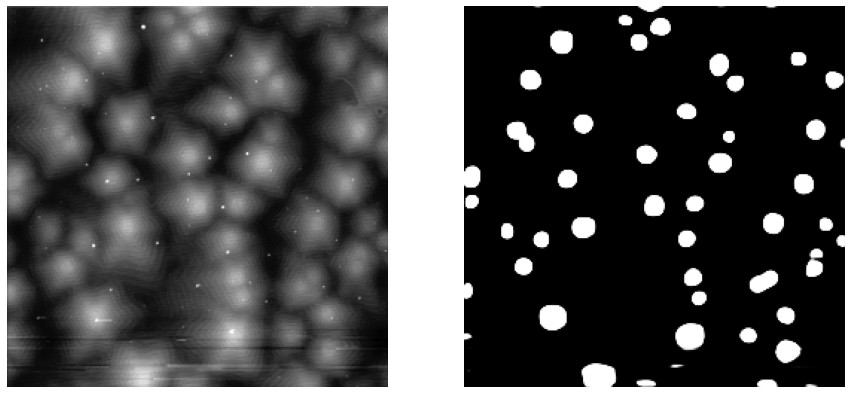

In [5]:
test_img = cv2.imread("F:/Images/preprocessed_images/V1767CG_T.png", cv2.IMREAD_COLOR)
test_img = cv2.resize(test_img, (SIZE_Y,SIZE_X))

fig, ax = plt.subplots(1, 2 ,figsize=(15,10))
ax[0].axis("off")
ax[0].imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY), cmap="gray")

test_img = np.expand_dims(test_img, axis=0)
pred_img = model_test.predict(test_img)
pred_img = pred_img.reshape((SIZE_X, SIZE_Y))

ax[1].axis("off")
ax[1].imshow(pred_img, cmap="gray")

The predicted image has pixel intensity range of (0,1)

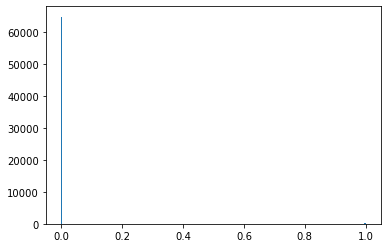

In [3]:
plt.hist(pred_img.ravel(), bins=256);

Convert the pixel intensity range to from (0,1) -> (0,255)

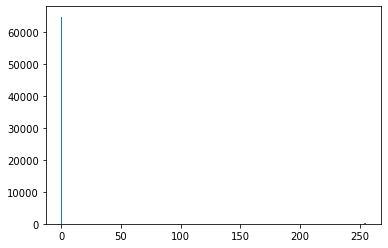

In [4]:
pred_img = 255 * pred_img
plt.hist(pred_img.ravel(), bins=256);

pred_img = pred_img.astype(np.uint8)

Thresholding to ensure that pixel value is either 0 or 255

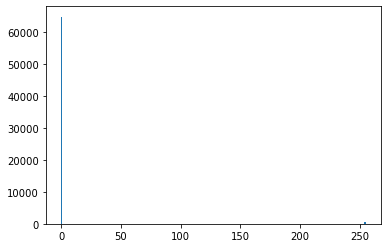

In [5]:
thresh_val, thresh_pred_img = cv2.threshold(pred_img, 120, 255, cv2.THRESH_BINARY + 
                                            cv2.THRESH_OTSU)
plt.hist(thresh_pred_img.ravel(), bins=256);

Detect objects using cv2.connectedComponentsWithStats()

In [6]:
# Choose between 4 or 8 for connectivity type
connectivity = 4

# num_labels is the number of detected objects including the background
# labels is an image showing the detected objects
# stats[label_index, COLUMN] is an array of (leftmost, topmost, width, height, area) of bounding box for each label
#   COLUMN can be cv2.CC_STAT_LEFT, cv2.CC_STAT_TOP, cv2.CC_STAT_WIDTH, cv2.CC_STAT_HEIGHT, cv2.CC_STAT_AREA
# centroid is an array of center coordinates for each label
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(thresh_pred_img, connectivity, cv2.CV_32S)

Drawing bounding circles in the original image

In [7]:
img_bounds = test_img.reshape((SIZE_X, SIZE_Y, 3))
img_bounds = cv2.cvtColor(img_bounds, cv2.COLOR_BGR2RGB)
# Green color
color = (0, 255, 0)
# 1px thickness
thickness = 1

for i in range(num_labels-1):
  # cv2.circle(image, center_coordinates, radius, color, thickness)
  center_coor = [int(center) for center in centroids[i+1].tolist()]
  cv2.circle(img_bounds, center_coor, stats[i+1, cv2.CC_STAT_WIDTH], color, thickness)

Number of defects detected: 68


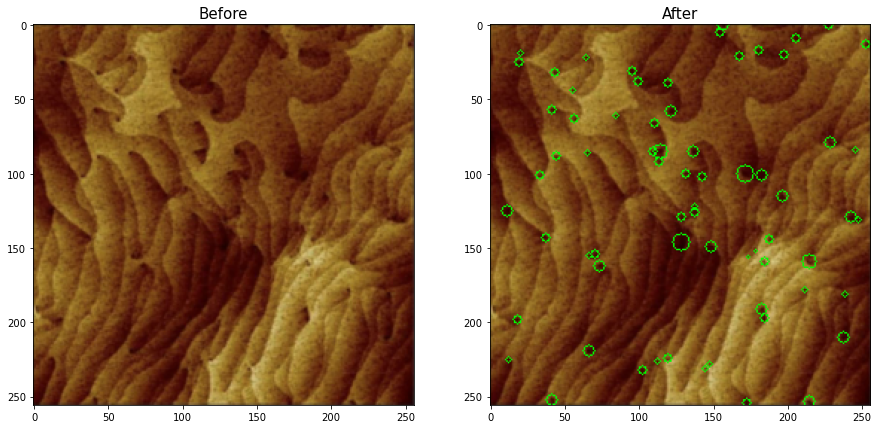

In [8]:
num_defects = num_labels-1

fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].imshow(cv2.cvtColor(test_img.reshape((SIZE_X, SIZE_Y, 3)), cv2.COLOR_BGR2RGB))
ax[0].set_title("Before", fontsize="15")
ax[1].imshow(img_bounds)
ax[1].set_title("After", fontsize="15")
print(f"Number of defects detected: {num_defects}")

In [9]:
defect_density = num_defects / (0.0005*0.0005)
print(f"Defect density: {defect_density:.2e} per cm^2")

Defect density: 2.72e+08 per cm^2
